In [192]:
import pandas as pd
data_url = "https://raw.githubusercontent.com/hunkim/DeepLearningZeroToAll/master/data-04-zoo.csv"

In [193]:
columns = ["hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator", "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type"]

data = pd.read_csv(data_url, names=columns, comment='#')
data.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,0
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,0
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,3
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,0
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,0


In [194]:
train_data = data.sample(frac=0.8, random_state=1)
test_data = data.drop(train_data.index)
x_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
x_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]


In [195]:
import tensorflow as tf
y_one_hot = tf.one_hot(indices=y_train, depth=7)
labels = tf.one_hot(indices=y_test, depth=7)
print(y_one_hot.shape)
print(x_train.shape)


(81, 7)
(81, 16)


## Train
$$ \hat{y} = Wx + b $$

## Softmax
```python

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# tf.nn.softmax
softmax = tf.exp(logits) / tf.reduce_sum(tf.exp(logits), axis, keepdims=True)
```

In [196]:
def softmax_loss(h, y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h, labels=y))


class SoftmaxRegression(tf.Module):
    def __init__(self):
        super(SoftmaxRegression, self).__init__()
        self.build = False
        
    def __call__(self, x, n_cases=1, train=True):
        if not self.build:
            self.w = tf.Variable(tf.random.uniform(shape=[x.shape[-1],n_cases]))
            self.b = tf.Variable(tf.random.uniform(shape=[n_cases]))
            self.build = True
        
        z = tf.add(tf.matmul(x, self.w), self.b)
        
        if train:
            return z
        
        return tf.nn.softmax(z)


softmax_regression = SoftmaxRegression()
X=tf.convert_to_tensor(x_train, dtype=tf.float32)
I=tf.convert_to_tensor(x_test, dtype=tf.float32)
y_val = softmax_regression(X, n_cases=7, train=False)
print(y_val.numpy()[:3])

[[0.3028403  0.07452698 0.3803162  0.17501211 0.01435124 0.02191387
  0.03103924]
 [0.14847696 0.0938708  0.40292382 0.21650502 0.04038908 0.07031155
  0.02752279]
 [0.2758707  0.07844242 0.44722033 0.14563751 0.01141769 0.02064954
  0.02076182]]


In [197]:
def predict_class(y_hat):
    return tf.math.argmax(y_hat)

def accuracy(y_hat, y):
    # y_hat = tf.math.softmax(y_hat)
    return tf.reduce_mean(tf.cast(tf.equal(tf.math.argmax(y_hat, 1), tf.math.argmax(y, 1)), tf.float32))
    

In [198]:
''' comment out 
iteration = 10000
learning_rate = 0.01
correct = 0
for step in range(iteration):    
    with tf.GradientTape() as tape:
        y_hypothesis = softmax_regression(X, n_cases=7)
        loss = softmax_loss(y_hypothesis, y_one_hot)
    correct = accuracy(y_hypothesis, y_one_hot)
    grads = tape.gradient(loss, softmax_regression.variables)
    for g, v in zip(grads, softmax_regression.variables):
        v.assign_sub(learning_rate * g)
    
    if correct == 1.0:
        print(f"step: {step}, correct: {correct}, loss: {loss}")
        break
    if step % 500 == 0:
        print(f"step: {step}, correct: {correct}, loss: {loss}")

print(f"correct: {correct}, loss: {loss}")
'''

' comment out \niteration = 10000\nlearning_rate = 0.01\ncorrect = 0\nfor step in range(iteration):    \n    with tf.GradientTape() as tape:\n        y_hypothesis = softmax_regression(X, n_cases=7)\n        loss = softmax_loss(y_hypothesis, y_one_hot)\n    correct = accuracy(y_hypothesis, y_one_hot)\n    grads = tape.gradient(loss, softmax_regression.variables)\n    for g, v in zip(grads, softmax_regression.variables):\n        v.assign_sub(learning_rate * g)\n    \n    if correct == 1.0:\n        print(f"step: {step}, correct: {correct}, loss: {loss}")\n        break\n    if step % 500 == 0:\n        print(f"step: {step}, correct: {correct}, loss: {loss}")\n\nprint(f"correct: {correct}, loss: {loss}")\n'

In [199]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X, y_one_hot))
train_dataset = train_dataset.shuffle(buffer_size=X.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((I, labels))
test_dataset = test_dataset.shuffle(buffer_size=I.shape[0]).batch(batch_size)

epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_corrects, test_corrects = [], []
softmax_regression = SoftmaxRegression()

for epoch in range(epochs):
    batch_losses_train, batch_correct_train = [], []
    batch_losses_test, batch_correct_test = [], []

    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred_batch = softmax_regression(x_batch, n_cases=7)
            batch_loss = softmax_loss(y_pred_batch, y_batch)        
        batch_correct = accuracy(y_pred_batch, y_batch)
        grads = tape.gradient(batch_loss, softmax_regression.variables)
        for g, v in zip(grads, softmax_regression.variables):
            v.assign_sub(learning_rate * g)
        batch_losses_train.append(batch_loss)
        batch_correct_train.append(batch_correct)

    for x_batch, y_batch in test_dataset:
        y_pred_batch = softmax_regression(x_batch)
        batch_loss = softmax_loss(y_pred_batch, y_batch)
        batch_correct = accuracy(y_pred_batch, y_batch)
        batch_losses_test.append(batch_loss)
        batch_correct_test.append(batch_correct)

    # Keep track of epoch-level model performance
    train_loss, train_correct = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_correct_train)
    test_loss, test_correct = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_correct_test)
    train_losses.append(train_loss)
    train_corrects.append(train_correct)
    test_losses.append(test_loss)
    test_corrects.append(test_correct)
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 3.003
Epoch: 20, Training log loss: 1.724
Epoch: 40, Training log loss: 1.622
Epoch: 60, Training log loss: 1.309
Epoch: 80, Training log loss: 1.185
Epoch: 100, Training log loss: 1.130
Epoch: 120, Training log loss: 0.949
Epoch: 140, Training log loss: 0.993
Epoch: 160, Training log loss: 0.997
Epoch: 180, Training log loss: 0.835


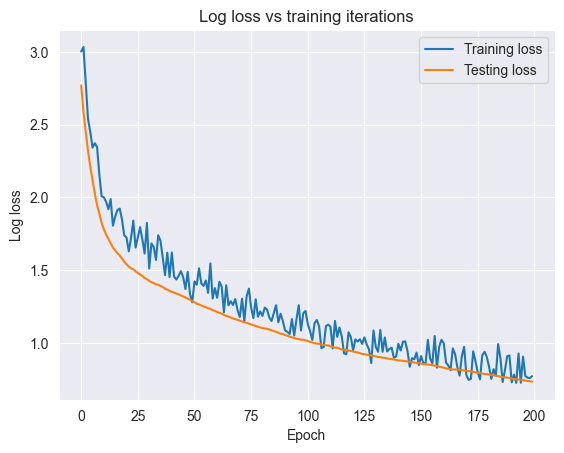

In [200]:
import matplotlib
from matplotlib import pyplot as plt

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

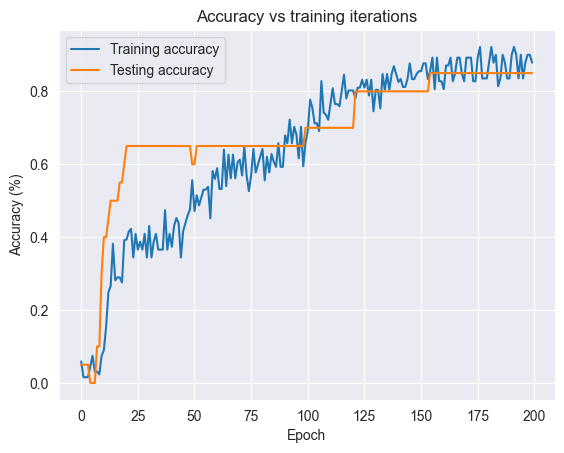

In [201]:
plt.plot(range(epochs), train_corrects, label = "Training accuracy")
plt.plot(range(epochs), test_corrects, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");